## MUT20 Player Scraper Usage Example
- Date is only used to track scrape date, url is the first page of the pages you want to scrape on Muthead.

TODO: 
- Finish mapping archetype ids (int) to actual archetype name and implement

- RB Speed v Date (w PU +3 - seperate col - PU-Physical_speed?)
- DB Speed v RB Speed v Time

In [2]:
from MUTScraper20 import Player, PlayerHandler, JSONParser
import pandas as pd
from datetime import datetime

%load_ext autoreload
%autoreload 2


def parse_json(date):
    jp = JSONParser(date=date)
    jp.load_json()
    jp.parse_json_items()
    jp.jsons_to_dataframe()
    jp.save_to_csv()
    return jp


# Start here by inputting date and link
date = datetime.now().strftime("%d-%m-%Y")
url = 'https://www.muthead.com/20/players/?overall__gte=87'

ph = PlayerHandler(date=date, url=url)
ph.handle_players()
jp = parse_json(date)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of pages: 70
https://www.muthead.com/20/players/?overall__gte=87
1395 player links gathered.
Filtering player list, before: 1395
Completed filtering, after: 234



In [13]:
#len(ph.player_dicts) # 568
#pdf = pd.DataFrame(ph.player_dicts)
#pdf.to_csv('14-02-2020_players.csv')

#jp.df_dict['OFF']
new_df = jp.df_dict['OFF']
print(new_df.shape)
path = 'data/OFF.csv'
df = pd.read_csv(path)
print(df.shape)
assert df.shape[1] == new_df.shape[1]
df = pd.concat([df, new_df])
df.to_csv(path, index=False)
df.shape

new_df = jp.df_dict['QB']
print(new_df.shape)
path = 'data/QB.csv'
df = pd.read_csv(path)
print(df.shape)
assert df.shape[1] == new_df.shape[1]
df = pd.concat([df, new_df])
df.to_csv(path, index=False)
df.shape

new_df = jp.df_dict['OFF']
print(new_df.shape)
path = 'data/OFF.csv'
df = pd.read_csv(path)
print(df.shape)
assert df.shape[1] == new_df.shape[1]
df = pd.concat([df, new_df])
df.to_csv(path, index=False)
df.shape

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set();


# Not implemented yet
# Hester, Dante Hall - 47: Unknown
archetype_map = {#Offensive
                 4: 'Field General (QB)', 16: 'Improvisor (QB)', 40: 'Scrambler (QB)', 45: 'Strong Arm (QB)',
                 5: 'Physical (WR)', 8: 'Route Running (WR)', 10: 'Deep Threat (WR)', 36: 'Slot (WR)',
                 47: 'Returner (WR)',
                 26: 'Elusive Back (HB)', 30: 'Powerback (HB)', 33: 'Receiving Back (HB)',
                 15: 'Power (OT)', 7: 'Pass Protector (OT)',
                 11: 'Power (OG)', 19: 'Pass Protector (OG)', 46: 'Agile (OG)',
                 18: 'Power (C)', 38: 'Agile (C)', 39: 'Pass Protector (C)',
                 3: 'Vertical Threat (TE)', 14: 'Blocking (TE)', 44: 'Possession (TE)',
                 1: 'Man-to-Man (CB)', 24: 'Slot (CB)', 37: 'Zone (CB)', 
                 # Defensive
                 2: 'Hybrid (FS/SS)', 17: 'Zone (FS/SS)', 21: 'Run Support (FS/SS)'
                 }

def get_archtype(arch_id):
    if arch_id in archetype_map.keys():
        return archetype_map[arch_id]
    else:
        return 'N/A'
    
enforcer_dict = {1: {'OVR': 95, 'POW': 95}, 
                 24: {'OVR': 95, 'POW': 95},
                 37: {'OVR': 95, 'POW': 95},
                 2: {'OVR': 0, 'POW': 90},
                 21: {'OVR': 0, 'POW': 90},
                 17: {'OVR': 95, 'POW': 95}}


def enforcer_check(arch_id, ovr, hit_power, pu):
    
    if arch_id not in archetype_map.keys():
        return 'N/A'
    elif arch_id not in enforcer_dict.keys():
        return False
    
    if pu:
        hit_power = hit_power + 1
        ovr = ovr + 1
        
    requirements = enforcer_dict[arch_id]
    if ovr >= requirements['OVR'] and hit_power >= requirements['POW']:
        return True
    return False

def reorder_df(df):
    come_first = ['name', 'OVR', 'program', 'position']
    cols = list(df.columns)
    _ = [cols.remove(c) for c in come_first]
    cols = come_first + cols
    return df[cols]
        
def filter_df(df, positions, sort_by=None):
    """
    """
    if type(positions) != list: 
        positions = [positions]
    result = df[ df['position'].isin(positions)]
    if sort_by:
        return result.sort_values(sort_by, ascending=False)
    return result


def mark_top_cards(df): # for PU's
    """
    (in-place operation) Adds column where ideally 1 implies it melts into players Power Up path, 
    many edge cases to consider for lower overall players
    """
    player_ids = []
    name_prog_tuples = df.groupby(['name', 'program'])['OVR'].max().index
    ovrs = df.groupby(['name', 'program'])['OVR'].max().values
    for (name, program), ovr in zip(name_prog_tuples, ovrs):
        player_ids.append(df[ (df['name']==name) & (df['program']==program) & (df['OVR']==ovr)]['player_id'].values[0])
    mc_ids = df[ df['program']=='Madden Challenge']['player_id'].values
    df['top_card'] = df['player_id'].apply(lambda x: x in player_ids and x not in mc_ids)    

def add_PU_stat(df, stat):
    """
    (in-place operation) 
    """
    df['_'.join(['PU', stat])] = df[stat] + (df['has_power_up']*1).fillna(0)*(df['top_card']*1).fillna(0)
    
def add_PU_speed(df):
    df['PU_SPD'] = df['SPD'] + (df['has_power_up']*3).fillna(0)*(df['top_card']*1).fillna(0)

## Viewing our data

In [38]:
import os
import pandas as pd


directory = 'data'
drop_duplicates = True
index_issue = False
save = False

dfs = {}

for file in os.listdir(directory):
    if '.csv' in file:
        #print(directory, file)
        df = pd.read_csv(os.path.join(directory, file))
        
        if index_issue:
            # shouldn't need, index problem 
            df = df[df.columns.difference(['Unnamed: 0'])]
        
        # dropping duplicates because of previous error
        if drop_duplicates:
            df = df.drop_duplicates(subset=df.columns.difference(['date_scraped']))
        
        if save:
            df.to_csv(os.path.join(directory, file), index=False)
            
        dfs[file.split('.csv')[0]] = df
        

_ = [print(k, v.shape) for k,v in dfs.items()]

for k, v in dfs.items():
    mark_top_cards(v)
    add_PU_speed(v)
    dfs[k] = reorder_df(v)

    
# RB/WR Speed vs DB/LB? Speed over Time
qbs = dfs['QB']
rbs = filter_df(dfs['OFF'], ['HB'])
wrs = filter_df(dfs['OFF'], ['WR'])
dbs = filter_df(dfs['DEF'], ['CB', 'FS', 'SS'])
sub_lbs = filter_df(dfs['DEF'], ['LOLB', 'ROLB', 'MLB', 'FS', 'SS'])
lbs = filter_df(dfs['DEF'], ['LOLB', 'MLB', 'ROLB'])
#dbs['enforcer'] = holder.apply(lambda x: enforcer_check(x[0], x[1], x[2], x[3]), axis=1)

# O-Line PBF vs D-Line FNM
oline = filter_df(dfs['OFF'], ['LT', 'LG', 'C', 'RG','RT'])#, 'TAK')[['name', 'TAK', 'POW', 'SPD', 'HT']]
dline = filter_df(dfs['DEF'], ['LE', 'DT', 'RE', 'LOLB','ROLB'])#, 'TAK')[['name', 'TAK', 'POW', 'SPD', 'HT']]

DEF (719, 70)
OFF (779, 70)
ST (60, 65)
QB (129, 76)


In [44]:
#mark_top_cards(qbs)
#add_PU_stat(qbs, 'MAC')
#qbs[ qbs['PU_MAC']==89]['MAC']

rbs.sort_values('PU_SPD', ascending=False).head(10)[['name', 'PU_SPD']]

,name,PU_SPD
296,Bo Jackson,98
753,Eric Dickerson,98
700,Saquon Barkley,98
231,Chris Johnson,97
121,Chris Johnson,97
518,Marcus Allen,97
751,Dalvin Cook,97
109,Barry Sanders,96
491,Christian McCaffrey,96
668,Raheem Mostert,96


In [25]:
def add_others(df):
    df['SPD-OVR'] = df['PU_SPD'] - df['OVR']
    df['AGI-OVR'] = df['AGI'] - df['OVR']
    df = df[ df['program'] != 'Series Redux']

def get_plotdf(df): # pass through filtered df or from dfs['OFF'] etc.
    #mark_top_cards(df)
    #add_PU_speed(df)
    add_others(df)
    cols = ['name', 'OVR', 'position', 'program', 'release_date', 'PU_SPD', 'AGI', 'SPD-OVR','AGI-OVR']
    plotdf = df.copy()[cols].sort_values('release_date')
    plotdf['release_date'] = plotdf['release_date'].astype(pd.datetime)
    plotdf['dt'] = plotdf['release_date'].apply(lambda x: pd.to_datetime(x))
    plotdf['date_day'] = plotdf['dt'].apply(lambda x: x.date())
    plotdf['days_since_release'] = datetime.now().date() - plotdf['date_day']

    plotdf.reset_index(drop=True, inplace=True)
    return plotdf


rb_df = get_plotdf(rbs)
db_df = get_plotdf(dbs)
lb_df = get_plotdf(lbs)
sub_lb_df = get_plotdf(sub_lbs)

/Users/mattjohnson/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mattjohnson/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mattjohnson/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

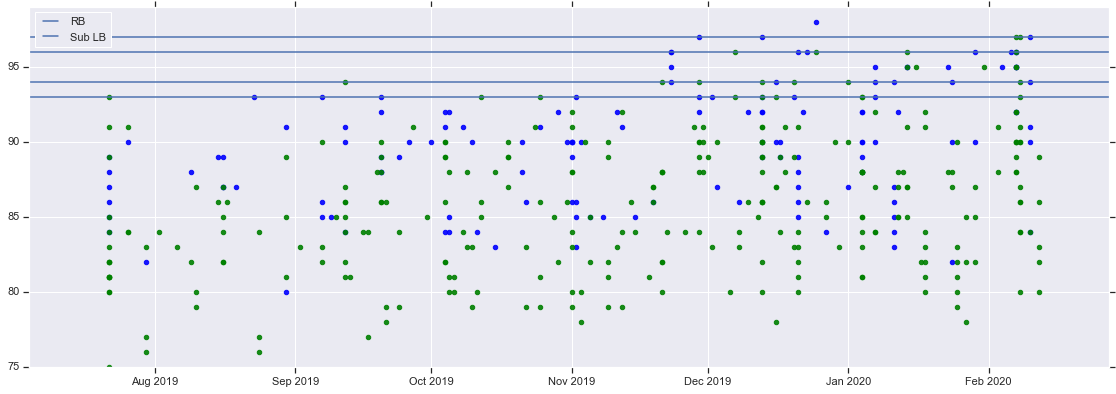

In [33]:

# FIGURE 1
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])

#date = plotdf.release_date.astype('O')
#ax.bar(date, plotdf['SPD'])
plt.scatter(rb_df['date_day'].tolist(), rb_df['PU_SPD'], color='blue', alpha=0.9);
#plt.scatter(db_df['date_day'].tolist(), db_df['PU_SPD'], color='red', alpha=0.9);
#plt.scatter(lb_df['date_day'].tolist(), lb_df['PU_SPD'], color='green', alpha=0.9);
plt.scatter(sub_lb_df['date_day'].tolist(), sub_lb_df['PU_SPD'], color='green', alpha=0.9);

maxes = {'date': [], 'attrib': []}
max_ = 0
for date, attrib in zip(sub_lb_df['date_day'].tolist(), sub_lb_df['PU_SPD'].values):
    if attrib > max_:
        if date in maxes['date']:
            maxes['date'].pop()
            maxes['attrib'].pop()
        maxes['date'].append(date)
        maxes['attrib'].append(attrib)
        max_ = attrib
        
#plt.plot(maxes['date'], maxes['attrib'], 'green')
for i in range(len(maxes['date'])):
    #print(maxes['date'][i], maxes['date'][i+1])
    #plt.axhline(y=maxes['attrib'][i], xmin=maxes['date'][i], xmax=maxes['date'][i+1], linewidth=1)
    plt.axhline(y=maxes['attrib'][i])#, xmin=maxes['date'][i])# xmax=20, linewidth=1)
    
plt.ylim(75, 99);
plt.legend(['RB', 'Sub LB'], loc='upper left');
# set labels

In [26]:
rb_df[ rb_df['PU_SPD'] >= 95].sort_values('PU_SPD', ascending=False).drop(['release_date', 'dt'],axis=1)

,name,OVR,position,program,PU_SPD,AGI,SPD-OVR,AGI-OVR,date_day,days_since_release
94,Bo Jackson,95,HB,Ghosts of Madden - Past,98,92,3,-3,2019-12-25,53 days
135,Marcus Allen,96,HB,Ultimate Legends,97,94,1,-2,2020-02-10,6 days
70,Chris Johnson,94,HB,Blitz,97,93,3,-1,2019-11-29,79 days
79,Chris Johnson,94,HB,Series Redux,97,93,3,-1,2019-12-13,65 days
65,Barry Sanders,94,HB,NFL 100,96,95,2,1,2019-11-23,85 days
130,Garrison Hearst,95,HB,Theme Diamonds,96,94,1,-1,2020-02-07,9 days
127,Edgerrin James,95,HB,Theme Diamonds,96,94,1,-1,2020-02-07,9 days
123,Christian McCaffrey,97,HB,NFL Honors,96,99,-1,2,2020-02-06,10 days
120,Raheem Mostert,96,HB,Super Bowl Present,96,91,0,-5,2020-01-29,18 days
64,Eric Dickerson,94,HB,NFL 100,96,92,2,-2,2019-11-23,85 days


In [27]:
rb_df[ rb_df['PU_SPD'] >= 95].sort_values('AGI-OVR', ascending=False).drop(['release_date', 'dt'],axis=1)

,name,OVR,position,program,PU_SPD,AGI,SPD-OVR,AGI-OVR,date_day,days_since_release
106,Saquon Barkley,93,HB,Team of the Week,95,96,2,3,2020-01-07,40 days
114,Tarik Cohen,95,HB,Team of the Year,95,97,0,2,2020-01-14,33 days
123,Christian McCaffrey,97,HB,NFL Honors,96,99,-1,2,2020-02-06,10 days
65,Barry Sanders,94,HB,NFL 100,96,95,2,1,2019-11-23,85 days
122,Chris Johnson,95,HB,Madden Challenge,95,95,0,0,2020-02-04,12 days
128,Brian Westbrook,95,HB,Theme Diamonds,95,95,0,0,2020-02-07,9 days
130,Garrison Hearst,95,HB,Theme Diamonds,96,94,1,-1,2020-02-07,9 days
70,Chris Johnson,94,HB,Blitz,97,93,3,-1,2019-11-29,79 days
79,Chris Johnson,94,HB,Series Redux,97,93,3,-1,2019-12-13,65 days
93,Walter Payton,95,HB,Zero Chill,96,94,1,-1,2019-12-23,55 days


In [ ]:
# allen 89 (90pus)
# sayers 91 (93pus), portis 92 (93pus), 

In [24]:
rb_df.columns

Index(['name', 'OVR', 'position', 'program', 'release_date', 'PU_SPD', 'AGI',
       'dt', 'date_day', 'days_since_release'],
      dtype='object')

In [304]:
rb_df[ rb_df['PU_SPD'] >= 95].sort_values('PU_SPD', ascending=False).drop(['release_date', 'dt'],axis=1)

,name,OVR,position,program,PU_SPD,AGI,date_day,days_since_release,SPD-OVR
94,Bo Jackson,95,HB,Ghosts of Madden - Past,98,92,2019-12-25,53 days,3
135,Marcus Allen,96,HB,Ultimate Legends,97,94,2020-02-10,6 days,1
70,Chris Johnson,94,HB,Blitz,97,93,2019-11-29,79 days,3
65,Barry Sanders,94,HB,NFL 100,96,95,2019-11-23,85 days,2
130,Garrison Hearst,95,HB,Theme Diamonds,96,94,2020-02-07,9 days,1
127,Edgerrin James,95,HB,Theme Diamonds,96,94,2020-02-07,9 days,1
123,Christian McCaffrey,97,HB,NFL Honors,96,99,2020-02-06,10 days,-1
120,Raheem Mostert,96,HB,Super Bowl Present,96,91,2020-01-29,18 days,0
64,Eric Dickerson,94,HB,NFL 100,96,92,2019-11-23,85 days,2
93,Walter Payton,95,HB,Zero Chill,96,94,2019-12-23,55 days,1


In [218]:
sub_lb_df[ sub_lb_df['PU_SPD'] >= 94].sort_values('PU_SPD', ascending=False).drop(['release_date', 'dt'],axis=1)

,name,OVR,position,program,PU_SPD,AGI,date_day
271,Taylor Mays,95,SS,Theme Diamonds,97,94,2020-02-07
278,Troy Polamalu,96,SS,Ultimate Legends,97,94,2020-02-08
161,Ed Reed,94,SS,NFL 100,96,93,2019-12-07
199,Sean Taylor,95,FS,Zero Chill,96,93,2019-12-25
229,Minkah Fitzpatrick,96,FS,Team of the Year,96,95,2020-01-14
230,Jamal Adams,96,SS,Team of the Year,95,88,2020-01-14
234,Budda Baker,95,FS,Signature Series,95,94,2020-01-16
258,Tyrann Mathieu,96,SS,Super Bowl Present,95,94,2020-01-31
268,Mike Brown,95,FS,Theme Diamonds,95,91,2020-02-07
47,Justin Reid,93,FS,Ultimate Kickoff,94,90,2019-09-12


In [102]:
#rb_df.sort_values('PU_SPD', ascending=False)
#rb_df[ rb_df['name']=='Eric Dickerson']
#rb_df
#rbs[ rbs['name']=='Eric Dickerson']['has_power_up']

In [126]:
rb_df.sort_values('PU_SPD', ascending=False).head(10)#['name']

,name,OVR,position,program,release_date,PU_SPD,dt,date_day
122,Chris Johnson,95,HB,Madden Challenge,2020-02-04T15:36:46.838965Z,98,2020-02-04 15:36:46.838965,2020-02-04
94,Bo Jackson,95,HB,Ghosts of Madden - Past,2019-12-25T15:36:44.221615Z,98,2019-12-25 15:36:44.221615,2019-12-25
131,Marcus Allen,86,HB,Ultimate Legends,2020-02-10T15:36:48.497522Z,97,2020-02-10 15:36:48.497522,2020-02-10
70,Chris Johnson,94,HB,Blitz,2019-11-29T01:19:02.431656Z,97,2019-11-29 01:19:02.431656,2019-11-29
79,Chris Johnson,94,HB,Series Redux,2019-12-13T16:37:36.619743Z,97,2019-12-13 16:37:36.619743,2019-12-13
65,Barry Sanders,94,HB,NFL 100,2019-11-23T02:44:55.324605Z,96,2019-11-23 02:44:55.324605,2019-11-23
93,Walter Payton,95,HB,Zero Chill,2019-12-23T15:36:43.668592Z,96,2019-12-23 15:36:43.668592,2019-12-23
130,Garrison Hearst,95,HB,Theme Diamonds,2020-02-07T15:36:50.504743Z,96,2020-02-07 15:36:50.504743,2020-02-07
123,Christian McCaffrey,97,HB,NFL Honors,2020-02-06T15:36:46.941514Z,96,2020-02-06 15:36:46.941514,2020-02-06
120,Raheem Mostert,96,HB,Super Bowl Present,2020-01-29T15:36:55.045196Z,96,2020-01-29 15:36:55.045196,2020-01-29


In [127]:
db_df.sort_values('PU_SPD', ascending=False).head(10)#['name']

,name,OVR,position,program,release_date,PU_SPD,dt,date_day
233,Tracy Porter,95,CB,Theme Diamonds,2020-02-07T15:36:50.506553Z,98,2020-02-07 15:36:50.506553,2020-02-07
135,Deion Sanders,94,CB,NFL 100,2019-12-07T02:20:53.335273Z,98,2019-12-07 02:20:53.335273,2019-12-07
217,Marshon Lattimore,95,CB,Signature Series,2020-01-30T15:36:47.471034Z,98,2020-01-30 15:36:47.471034,2020-01-30
234,Troy Polamalu,87,SS,Ultimate Legends,2020-02-08T15:36:55.967808Z,97,2020-02-08 15:36:55.967808,2020-02-08
191,Champ Bailey,96,CB,NFL Playoffs,2020-01-04T15:36:45.629755Z,97,2020-01-04 15:36:45.629755,2020-01-04
232,Marcus Trufant,95,CB,Theme Diamonds,2020-02-07T15:36:50.504972Z,97,2020-02-07 15:36:50.504972,2020-02-07
231,Taylor Mays,95,SS,Theme Diamonds,2020-02-07T15:36:50.503601Z,97,2020-02-07 15:36:50.503601,2020-02-07
203,Tre'Davious White,96,CB,Team of the Year,2020-01-14T15:36:46.375506Z,97,2020-01-14 15:36:46.375506,2020-01-14
227,Night Train Lane,98,CB,Theme Diamonds,2020-02-07T15:36:50.499747Z,97,2020-02-07 15:36:50.499747,2020-02-07
230,Antonio Cromartie,95,CB,Theme Diamonds,2020-02-07T15:36:50.503151Z,97,2020-02-07 15:36:50.503151,2020-02-07


In [128]:
lb_df.sort_values('PU_SPD', ascending=False).head(10)#['name']

,name,OVR,position,program,release_date,PU_SPD,dt,date_day
135,Patrick Willis,96,MLB,Ghosts of Madden - Past,2020-01-01T15:36:46.457690Z,94,2020-01-01 15:36:46.457690,2020-01-01
184,Brian Urlacher,86,MLB,Ultimate Legends,2020-02-08T15:36:55.968968Z,93,2020-02-08 15:36:55.968968,2020-02-08
179,Luke Kuechly,97,MLB,Series Redux,2020-02-07T15:36:50.499060Z,92,2020-02-07 15:36:50.499060,2020-02-07
143,Deion Jones,93,MLB,Team of the Week,2020-01-07T19:21:34.852920Z,92,2020-01-07 19:21:34.852920,2020-01-07
160,Luke Kuechly,97,MLB,M20 Tribute,2020-01-18T15:36:49.959052Z,92,2020-01-18 15:36:49.959052,2020-01-18
181,Brian Cushing,95,MLB,Theme Diamonds,2020-02-07T15:36:50.501781Z,92,2020-02-07 15:36:50.501781,2020-02-07
122,Devin Bush,93,MLB,Ghosts of Madden - Future,2019-12-18T15:36:43.192793Z,91,2019-12-18 15:36:43.192793,2019-12-18
151,Luke Kuechly,96,MLB,Team of the Year,2020-01-14T15:36:46.375956Z,91,2020-01-14 15:36:46.375956,2020-01-14
99,Lawrence Taylor,94,ROLB,NFL 100,2019-11-30T02:17:21.978498Z,91,2019-11-30 02:17:21.978498,2019-11-30
175,Derrick Brooks,96,ROLB,Super Bowl Past,2020-02-03T15:36:53.789764Z,91,2020-02-03 15:36:53.789764,2020-02-03


In [300]:
rb_df[ rb_df['name']=='Bo Jackson']

,name,OVR,position,program,release_date,PU_SPD,AGI,dt,date_day,days_since_release,SPD-OVR
14,Bo Jackson,91,HB,Madden Ultimate Team 10,2019-08-23T20:41:23.204651Z,93,88,2019-08-23 20:41:23.204651,2019-08-23,176 days,2
94,Bo Jackson,95,HB,Ghosts of Madden - Past,2019-12-25T15:36:44.221615Z,98,92,2019-12-25 15:36:44.221615,2019-12-25,52 days,3


In [302]:
rb_df['SPD-OVR'] = rb_df['PU_SPD'] - rb_df['OVR']

rb_df.sort_values('SPD-OVR', ascending=False).head(20)

,name,OVR,position,program,release_date,PU_SPD,AGI,dt,date_day,days_since_release,SPD-OVR
131,Marcus Allen,86,HB,Ultimate Legends,2020-02-10T15:36:48.497522Z,94,94,2020-02-10 15:36:48.497522,2020-02-10,5 days,8
98,Raheem Mostert,87,HB,NFL Playoffs,2020-01-04T15:36:45.618013Z,92,86,2020-01-04 15:36:45.618013,2020-01-04,42 days,5
104,Nyheim Hines,86,HB,Team of the Week,2020-01-07T19:21:34.854925Z,90,87,2020-01-07 19:21:34.854925,2020-01-07,39 days,4
105,Phillip Lindsay,89,HB,Team of the Week,2020-01-07T19:21:34.855815Z,93,87,2020-01-07 19:21:34.855815,2020-01-07,39 days,4
68,Matt Breida,88,HB,Blitz,2019-11-29T01:19:02.427896Z,92,87,2019-11-29 01:19:02.427896,2019-11-29,78 days,4
2,Lamar Miller,86,HB,Theme Builders,2019-07-22T21:55:54.197275Z,89,86,2019-07-22 21:55:54.197275,2019-07-22,208 days,3
94,Bo Jackson,95,HB,Ghosts of Madden - Past,2019-12-25T15:36:44.221615Z,98,92,2019-12-25 15:36:44.221615,2019-12-25,52 days,3
70,Chris Johnson,94,HB,Blitz,2019-11-29T01:19:02.431656Z,97,93,2019-11-29 01:19:02.431656,2019-11-29,78 days,3
27,Adrian Peterson,86,HB,Veterans,2019-09-20T14:36:44.446706Z,88,84,2019-09-20 14:36:44.446706,2019-09-20,148 days,2
91,Ahman Green,94,HB,Legends,2019-12-21T15:36:44.337281Z,96,91,2019-12-21 15:36:44.337281,2019-12-21,56 days,2


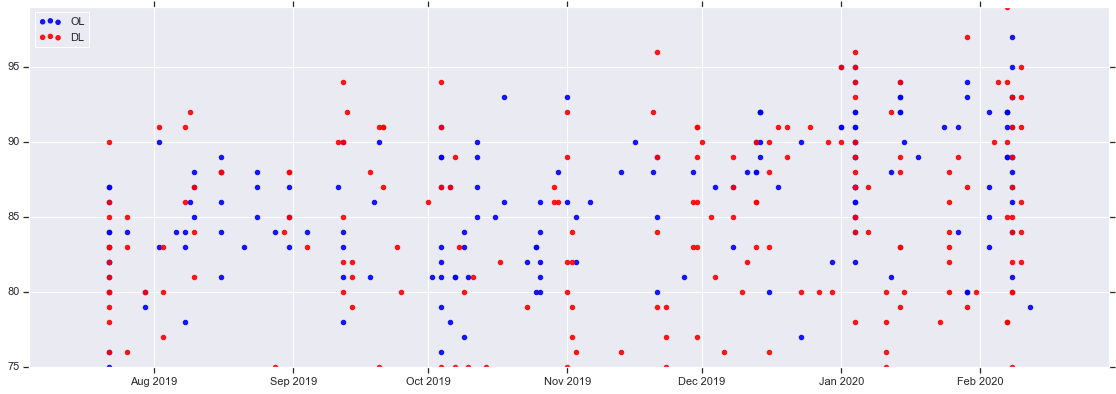

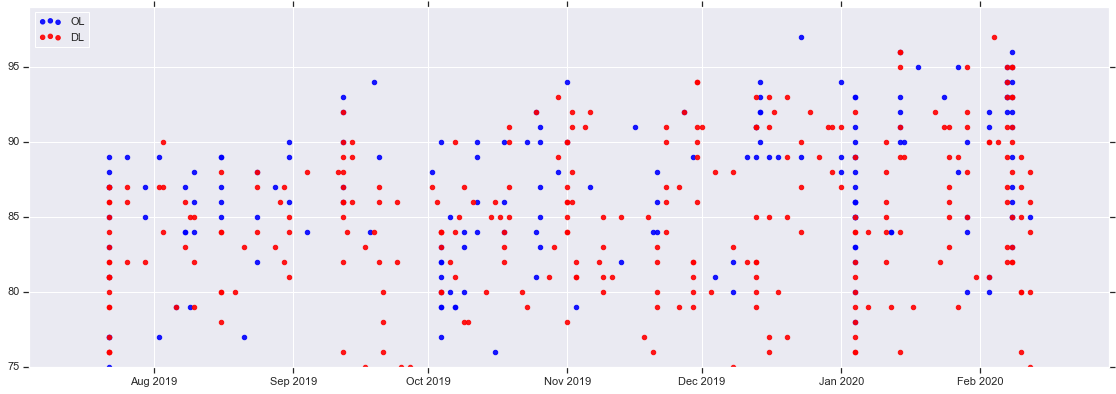

In [28]:
def get_plotdf2(df, pos='ol'): # pass through filtered df or from dfs['OFF'] etc.
    #mark_top_cards(df)
    #add_PU_speed(df)
    if pos.lower() == 'ol':
        cols = ['name', 'OVR', 'position', 'program', 'release_date', 'PBF', 'PBP', 'RBK']
    else:
        cols = ['name', 'OVR', 'position', 'program', 'release_date', 'FNM', 'PWM', 'BKS', 'WT', 'SPD']
    plotdf = df.copy()[cols].sort_values('release_date')
    plotdf['release_date'] = plotdf['release_date'].astype(pd.datetime)
    #plotdf.set_index('release_date', inplace=True)
    plotdf['dt'] = plotdf['release_date'].apply(lambda x: pd.to_datetime(x))
    plotdf['date_day'] = plotdf['dt'].apply(lambda x: x.date())
    #plt.plot(plotdf['release_date'], plotdf['SPD'])#plotdf['release_date'] = plotdf[]
    plotdf.reset_index(drop=True, inplace=True)
    return plotdf

ol_df = get_plotdf2(oline, 'ol')
dl_df = get_plotdf2(dline, 'dl')

# FIGURE 1
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])

#date = plotdf.release_date.astype('O')
#ax.bar(date, plotdf['SPD'])
plt.scatter(ol_df['date_day'].tolist(), ol_df['PBF'], color='blue', alpha=0.9);
plt.scatter(dl_df['date_day'].tolist(), dl_df['FNM'], color='red', alpha=0.9);
#plt.scatter(lb_df['date_day'].tolist(), lb_df['PU_SPD'], color='green', alpha=0.9);

plt.ylim(75, 99);
plt.legend(['OL', 'DL'], loc='upper left');
# set labels

# FIGURE 1
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])

#date = plotdf.release_date.astype('O')
#ax.bar(date, plotdf['SPD'])
plt.scatter(ol_df['date_day'].tolist(), ol_df['RBK'], color='blue', alpha=0.9);
plt.scatter(dl_df['date_day'].tolist(), dl_df['BKS'], color='red', alpha=0.9);
#plt.scatter(lb_df['date_day'].tolist(), lb_df['PU_SPD'], color='green', alpha=0.9);

plt.ylim(75, 99);
plt.legend(['OL', 'DL'], loc='upper left');
# set labels

In [31]:
dl_df['fnm_bks_avg'] = (dl_df['FNM'] + dl_df['BKS'])/2
dl_df.sort_values('fnm_bks_avg', ascending=False).head(10)

,name,OVR,position,program,release_date,FNM,PWM,BKS,WT,SPD,dt,date_day,fnm_bks_avg
262,Aaron Donald,97,RE,Team of the Year,2020-01-14T15:36:46.376626Z,94,97,96,280,84,2020-01-14 15:36:46.376626,2020-01-14,95.0
278,DeForest Buckner,96,DT,Super Bowl Present,2020-01-29T15:36:55.044963Z,97,87,91,300,74,2020-01-29 15:36:55.044963,2020-01-29,94.0
307,Warren Sapp,97,DT,Ultimate Legends,2020-02-08T15:36:55.972886Z,93,95,95,303,80,2020-02-08 15:36:55.972886,2020-02-08,94.0
286,Calais Campbell,97,LE,NFL Honors,2020-02-04T15:36:46.838475Z,90,94,97,300,75,2020-02-04 15:36:46.838475,2020-02-04,93.5
229,John Randle,95,DT,Ghosts of Madden - Past,2020-01-01T15:36:46.452155Z,95,90,91,290,80,2020-01-01 15:36:46.452155,2020-01-01,93.0
290,Joey Bosa,97,LE,Master,2020-02-07T15:36:50.499517Z,99,95,86,280,84,2020-02-07 15:36:50.499517,2020-02-07,92.5
263,Calais Campbell,96,LE,Team of the Year,2020-01-14T15:36:46.376849Z,89,92,96,300,74,2020-01-14 15:36:46.376849,2020-01-14,92.5
313,Julius Peppers,96,LE,Ultimate Legends,2020-02-10T15:36:48.497290Z,95,89,89,295,88,2020-02-10 15:36:48.497290,2020-02-10,92.0
233,Danielle Hunter,95,LE,NFL Playoffs,2020-01-04T15:36:45.614309Z,95,80,89,252,87,2020-01-04 15:36:45.614309,2020-01-04,92.0
287,Nick Bosa,96,RE,NFL Honors,2020-02-05T15:36:47.037984Z,94,90,90,266,82,2020-02-05 15:36:47.037984,2020-02-05,92.0


In [297]:
rb['archetype'] = rbs['archetype_id'].apply(lambda x: archetype_map[x])
sns.pairplot(rbs, hue='archetype');

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/mattjohnson/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-297-27307aab096f>", line 2, in <module>
    sns.pairplot(rbs, hue='archetype');
  File "/Users/mattjohnson/anaconda/lib/python3.5/site-packages/seaborn/axisgrid.py", line 2121, in pairplot
    plotter(scatterplot, **plot_kws)
  File "/Users/mattjohnson/anaconda/lib/python3.5/site-packages/seaborn/axisgrid.py", line 1512, in map_offdiag
    self.map_lower(func, **kwargs)
  File "/Users/mattjohnson/anaconda/lib/python3.5/site-packages/seaborn/axisgrid.py", line 1431, in map_lower
    plt.sca(ax)
  File "/Users/mattjohnson/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py", line 905, in sca
    m.canvas.figure.sca(ax)
  File "/Users/mattjohnson/anaconda/lib/python3.5/site-packages/matplotlib/figure.py", line 1363, in sca
    self._axstack.bubble(a)
  


Unfortunately, your original traceback can not be constructed.



KeyboardInterrupt: 

In [ ]:
#dfs['QB'].sort_values('OVR', ascending=False).head(10)
#filter_df(dfs['OFF'], 'HB', 'BTK')[['name', 'BTK', 'SPD', 'TRK', 'AGI']]
oline = filter_df(dfs['OFF'], ['LT', 'LG', 'C', 'RG', 'LT', 'RT','TE'])#, 'TAK')[['name', 'TAK', 'POW', 'SPD', 'HT']]
rbs = filter_df(dfs['OFF'], ['HB', 'FB'])
wrs = filter_df(dfs['OFF'], ['WR'])
dbs = filter_df(dfs['DEF'], ['CB', 'FS', 'SS'])
#dbs.groupby('archetype_id')[['archetype_id', 'name']].first()
dbs['enforcer'] = holder.apply(lambda x: enforcer_check(x[0], x[1], x[2], x[3]), axis=1)
oline['archetype'] = oline['archetype_id'].apply(get_archtype)
rbs['archetype'] = rbs['archetype_id'].apply(get_archtype)

#dbs.to_csv('dbs_jan11.csv', index=False)

In [53]:
# from: https://twitter.com/MUT_Leaks20/status/1156002794869911552
# 

# (x3, y3) = (350, 1.0)
import numpy as np


def get_weight_contribution_rbk(weight):
    (x1, y1), (x2, y2) = (150, 0), (290, 0.8)
    m1 = (y2-y1)/(x2-x1)
    b1 = -m1 * 150
    if weight <= 150: return 0
    elif weight <= 290: return m1*weight + b1
    return (1/300)*weight - (1/6)

def calc_run_block(rbk, weight, strength, vec=True):
    if vec:
        result = (0.6 * rbk) + (0.175 * weight.apply(lambda x: get_weight_contribution_rbk(x))) + (0.225 * strength)
    else:
        result = (0.6 * rbk) + (0.175 * get_weight_contribution_rbk(weight)) + (0.225 * strength)
    return result.apply(lambda x: np.round(x,1))
    
te = filter_df(dfs['OFF'], 'TE')
te = te[ te['program'] != 'Series Redux']
te['RBK_calc'] = calc_run_block(te['RBK'], te['WT'], te['STR'])
te['PBK_avg'] = ((te['PBF']+te['PBP'])/2).apply(lambda x: np.round(x, 1))
te['all_block'] = ((te['RBK_calc']+te['PBK_avg'])/2).apply(lambda x: np.around(x,1))
te_rbk = te.sort_values('PBK_avg', ascending=False).head(10)[
    ['name', 'program', 'SPD', 'CTH', 'RBK', 'WT', 'HT', 'STR', 'RBK_calc', 'PBF', 'PBP', 'PBK_avg']] # , 'all_block'
te_rbk.reset_index(drop=True)

,name,program,SPD,CTH,RBK,WT,HT,STR,RBK_calc,PBF,PBP,PBK_avg
0,Darren Waller,Blitz,89,90,75,255,78,67,60.2,79,83,81.0
1,Shannon Sharpe,Ultimate Legends,89,92,76,228,74,86,65.0,80,78,79.0
2,Darren Waller,Football Outsiders,86,86,72,255,78,64,57.7,76,80,78.0
3,Charles Clay,Veterans,82,87,71,255,75,74,59.4,77,78,77.5
4,Shannon Sharpe,Ultimate Legends,86,90,75,228,74,83,63.8,78,76,77.0
5,Dave Casper,Legends,85,90,73,240,76,80,61.9,78,75,76.5
6,Dave Casper,Legends,80,88,72,240,76,76,60.4,77,74,75.5
7,Rob Gronkowski,Zero Chill,86,93,79,265,78,87,67.1,74,77,75.5
8,Shannon Sharpe,Legends,79,85,72,228,74,77,60.6,76,74,75.0
9,Shannon Sharpe,Legends,84,87,72,228,74,81,61.5,76,74,75.0


In [39]:
from tabulate import tabulate

print(tabulate(te_rbk, tablefmt="pipe", headers="keys"))

ImportError: No module named 'tabulate'

In [42]:
#! pip3 install tabulate
#! pip install tabluate

def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    display(Markdown(df_formatted.to_csv(sep="|", index=False)))

print(pandas_df_to_markdown_table(te_rbk))

name|program|RBK|WT|HT|STR|RBK_calc|SPD|CTH
---|---|---|---|---|---|---|---|---
Marcedes Lewis|Flashbacks|87|267|78|81|70.542|74|84
George Kittle|Team of the Year|87|247|76|80|70.297|88|95
J.J. Watt|Out of Position|79|288|77|94|68.688|83|90
George Kittle|MUT Heroes|84|247|76|77|67.822|85|91
Tyler Higbee|Team of the Week|83|257|78|79|67.682|80|84
Delanie Walker|MUT Heroes|84|248|74|76|67.598|82|86
Rob Gronkowski|Zero Chill|79|265|78|87|67.09|86|93
Shannon Sharpe|Ultimate Legends|76|228|74|86|65.028|89|92
Alge Crumpler|Theme Diamonds|77|275|74|83|65.0|85|94
Mark Andrews|Team of the Week|77|253|77|82|64.753|88|92
Jason Witten|MUT Heroes|78|263|78|79|64.688|74|92
Hunter Henry|Team of the Week|80|250|77|71|64.075|80|82
Delanie Walker|Theme Builders|80|248|74|71|64.073|77|82
Rob Gronkowski|Madden Ultimate Team 10|75|265|78|84|64.015|83|89
George Kittle|Theme Builders|79|247|76|73|63.922|81|85


None


In [30]:
#calc_run_block(79, 288, 94, False)

oline['RBK_calc'] = calc_run_block(oline['RBK'], oline['WT'], oline['STR'])

#tes = oline[ oline['position'] == 'TE']
#tes.sort_values('RBK_calc', ascending=False)

stat_cols = ['RBK', 'IMP', 'LBK', 'SPD', 'AGI']
oline['pulling_guard'] = oline[stat_cols].mean(axis=1)
oline.sort_values('pulling_guard', ascending=False)[['OVR', 'name', 'program', 'position', 'pulling_guard', 'PBF', 'PBP', 'WT'] + stat_cols + ['RBK_calc']].head(25)
#oline['all_around_guard'] = oline[['RBK_calc', 'PBF', 'PBP', 'pulling_guard']].mean(1)
#oline.sort_values('all_around_guard', ascending=False)[['name', 'program', 'position', 'all_around_guard'] + stat_cols + ['PBF', 'PBP']].head(15)
#oline[ oline['position'] == 'TE'].sort_values('RBK_calc', ascending=False)[['name', 'program', 'position', 'RBK_calc', 'RBK', 'WT', 'STR', 'HT', 'SPD', 'CTH', 'CIT', 'SPC', 'SRR', 'MRR']].reset_index(drop=True)

/Users/mattjohnson/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/mattjohnson/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,OVR,name,program,position,pulling_guard,PBF,PBP,WT,RBK,IMP,LBK,SPD,AGI,RBK_calc
593,95,Lane Johnson,Super Bowl Past,RT,87.8,92,93,317,92,94,94,81,78,75.605750
643,97,Walter Jones,Ultimate Legends,LT,87.0,97,93,315,95,91,95,76,78,78.304583
514,96,Gene Upshaw,Super Bowl Past,LG,86.8,91,93,255,95,94,96,73,76,77.805000
499,95,Will Shields,Theme Diamonds,RG,86.0,92,91,315,94,92,95,75,74,77.029583
5,94,Jason Kelce,Zero Chill,C,85.2,90,83,295,97,89,93,73,74,77.242917
180,92,Lane Johnson,Blitz,RT,85.2,88,90,317,89,91,91,79,76,73.130750
252,92,Lane Johnson,Series Redux,RT,85.2,88,90,317,89,91,91,79,76,73.130750
462,95,Walter Jones,Ultimate Legends,LT,84.8,95,91,315,93,90,93,73,75,76.429583
142,93,Chris Lindstrom,Ghosts of Madden - Future,RG,84.8,87,89,307,89,93,96,76,70,73.574917
78,93,Chris Lindstrom,Rookie Premiere,RG,84.8,87,89,307,89,93,96,76,70,73.574917


In [292]:
oline.sort_values('RBK_calc', ascending=False)[['OVR', 'name', 'program', 'position', 'pulling_guard', 'PBF', 'PBP', 'WT'] + stat_cols + ['RBK_calc']].head(25)


,OVR,name,program,position,pulling_guard,PBF,PBP,WT,RBK,IMP,LBK,SPD,AGI,RBK_calc
498,96,Brian Waters,Ultimate Legends,LG,81.6,93,94,320,96,93,91,66,62,79.132500
536,96,Zack Martin,Team of the Year,RG,83.2,93,95,310,96,92,93,70,65,78.676667
566,96,Jon Runyan,Legends,RT,80.8,89,94,330,95,95,90,67,57,78.538333
628,96,Jon Runyan,Series Redux,RT,80.8,89,94,330,95,95,90,67,57,78.538333
643,97,Walter Jones,Ultimate Legends,LT,87.0,97,93,315,95,91,95,76,78,78.304583
76,94,Larry Allen,NFL 100,RG,80.8,90,92,335,94,93,89,66,62,77.941250
514,96,Gene Upshaw,Super Bowl Past,LG,86.8,91,93,255,95,94,96,73,76,77.805000
439,95,Eric Wood,Theme Diamonds,C,83.0,91,93,310,94,91,90,70,70,77.701667
182,94,Jonathan Ogden,NFL 100,RT,78.4,89,93,340,93,94,86,60,59,77.344167
674,95,Erik Williams,Theme Diamonds,RT,82.8,89,93,311,93,93,93,68,67,77.327250
